In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import codecs
import collections
import pickle

import sentiment_aware as sa

### Define variables

In [3]:
home = "SAFC"
away = "COYS"

### Load Data and Preprocessing

In [4]:
# Read file
tweets_file = open("../../EPLdata/GW5/1509132130_SAFCvsCOYS.txt", "r")

In [5]:
# Parsing JSON

tweets_data = []
for line in tweets_file:
    try:
        tweet = json.loads(line)
        if "text" in tweet:
            tweets_data.append(tweet)
    except:
        continue

In [6]:
tweets_file.close()

In [7]:
print len(tweets_data)

4333


### Create DataFrame as tweets

In [8]:
tweets = pd.DataFrame()
tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['hashtags'] = map(lambda tweet: map(lambda tag: tag['text'], tweet['entities']['hashtags']), tweets_data)

In [9]:
# 0: no tags, 3: both team tags, 1: only home team tags, 2: only away team tags, 4: other tags
def find_tag(tag):
    if not tag:
        return 0
    if home in tag and away in tag:
        return 3
    if home in tag:
        return 1
    if away in tag:
        return 2
    else:
        return 4

tweets["tag_num"] = map(lambda tags: find_tag(tags), tweets['hashtags'])

In [10]:
tweets[:20]

,text,lang,hashtags,tag_num
0,RT @SpursOfficial: KICK-OFF! Sunderland v Tott...,en,[COYS],2
1,Come on you spurs! #THFC #COYS,en,"[THFC, COYS]",2
2,RT @ChronicleSAFC: And we're off... #safc v #S...,en,"[safc, Spurs]",4
3,RT @ChronicleSAFC: And we're off... #safc v #S...,en,"[safc, Spurs]",4
4,"#COYS looking forward to sons debut, need a wi...",en,[COYS],2
5,RT @ChronicleSAFC: And we're off... #safc v #S...,en,"[safc, Spurs]",4
6,RT @SpursOfficial: The players are in the tunn...,en,[COYS],2
7,And we are underway at the Stadium Of Light #S...,en,"[SUNTOT, COYS]",2
8,are you ready for some football?? across the p...,en,[COYS],2
9,Today is the busiest it's ever been on the tra...,en,"[GNR, safc]",4


In [11]:
home_hashtags = len(tweets[tweets["tag_num"] == 1])
away_hashtags = len(tweets[tweets["tag_num"] == 2])
both_hashtags = len(tweets[tweets["tag_num"] == 3])
no_hashtags = len(tweets[tweets["tag_num"] == 4])
other_hashtags = len(tweets[tweets["tag_num"] == 0])

print "Home Team Tags: ", home_hashtags
print "Away Team Tags: ", away_hashtags
print "Both Team Tags: ", both_hashtags
print "Other Team Tags: ", other_hashtags
print "No Tags: \t", no_hashtags
print "All Tweets: ", len(tweets)

Home Team Tags:  713
Away Team Tags:  2448
Both Team Tags:  359
Other Team Tags:  95
No Tags: 	718
All Tweets:  4333


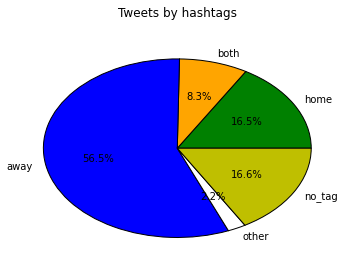

In [12]:
# Plot Hashtags Pie
slices = [home_hashtags, both_hashtags, away_hashtags, other_hashtags, no_hashtags]
activities = ['home','both','away', 'other', 'no_tag']
cols = ['g','orange','b', 'w', 'y']

plt.pie(slices,
        labels=activities,
        colors=cols,
        autopct='%1.1f%%')

plt.title('Tweets by hashtags\n')
plt.show()

In [13]:
# using only english tweets
tweets_eng = tweets[tweets["lang"] == "en"]
tweets_eng.head()

,text,lang,hashtags,tag_num
0,RT @SpursOfficial: KICK-OFF! Sunderland v Tott...,en,[COYS],2
1,Come on you spurs! #THFC #COYS,en,"[THFC, COYS]",2
2,RT @ChronicleSAFC: And we're off... #safc v #S...,en,"[safc, Spurs]",4
3,RT @ChronicleSAFC: And we're off... #safc v #S...,en,"[safc, Spurs]",4
4,"#COYS looking forward to sons debut, need a wi...",en,[COYS],2


In [14]:
print len(tweets_eng)

4333


### Sentiment of EPL Tweets: Using Saved Classifier (Movie Reviews Naive Bayes)

In [15]:
# read saved classifier
saved_classifier_f = open("pickled_algos/naiveBayes_for_short_reviews.pickle", "rb")
saved_classifier = pickle.load(saved_classifier_f)
saved_classifier_f.close()

# read saved word features
word_features5k_f = open("pickled_algos/word_features5k_shortReviews.pickle", "rb")
word_features = pickle.load(word_features5k_f)
word_features5k_f.close()

# Define Sentiment Tokenizer Class as tok
tok = sa.Tokenizer(preserve_case=False)
def find_features(document):
    words = tok.tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Define Sentiment Analysis function. Using aboves
def sentiment(text):
    return saved_classifier.classify(find_features(text))

In [16]:
# Create DataFrames for home and away tweets
home_tweets = tweets_eng[tweets_eng["tag_num"] == 1]
away_tweets = tweets_eng[tweets_eng["tag_num"] == 2]
home_tweets = pd.DataFrame(home_tweets.values, range(len(home_tweets)), home_tweets.columns)
away_tweets = pd.DataFrame(away_tweets.values, range(len(away_tweets)), away_tweets.columns)

## Sentiment Analysis

In [17]:
home_sent = map(lambda tweet: sentiment(tweet), home_tweets["text"])
away_sent = map(lambda tweet: sentiment(tweet), away_tweets["text"])
print "Home Team:", collections.Counter(home_sent)
print "Away Team:", collections.Counter(away_sent)

Home Team: Counter({'pos': 442, 'neg': 271})
Away Team: Counter({'pos': 1339, 'neg': 1109})


In [18]:
home_sent = collections.Counter(home_sent)
away_sent = collections.Counter(away_sent)

Positive Tweets:  442
Negative Tweets:  271


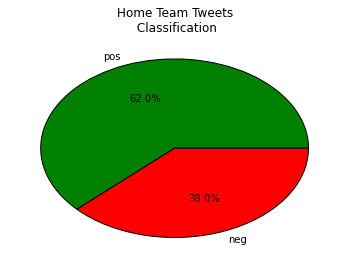

In [19]:
# Pie graph for home teams

slices = [home_sent['pos'], home_sent['neg']]
activities = ['pos', 'neg']
cols = ['g','r']

plt.pie(slices,
        labels=activities,
        colors=cols,
        autopct='%1.1f%%')

plt.title('Home Team Tweets \n Classification')

print "Positive Tweets: ", home_sent['pos']
print "Negative Tweets: ", home_sent['neg']

plt.show()

Positive Tweets:  1339
Negative Tweets:  1109


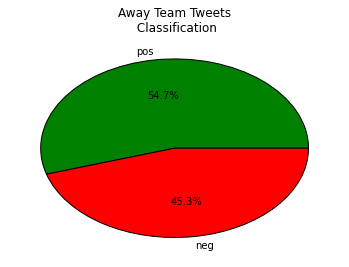

In [20]:
slices = [away_sent['pos'], away_sent['neg']]
activities = ['pos', 'neg']
cols = ['g','r']

plt.pie(slices,
        labels=activities,
        colors=cols,
        autopct='%1.1f%%')

plt.title('Away Team Tweets \n Classification')

print "Positive Tweets: ", away_sent['pos']
print "Negative Tweets: ", away_sent['neg']

plt.show()